<a href="https://colab.research.google.com/github/danil99152/prediction-of-government-tenders/blob/main/Data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Changelog



25.01.21
*   Удаление выбросов по времени
*   Смена графика цена время с line на scatter



30.01.21

*   Обработку даты с использованием встроенных методов pandas
*   Новые  столбцы в dataframe
*   Удаление контрактов-дупликатов по номеру в реестре
*   Обновление данных о стадии выполнения
*   Рефактор кода
*   Средняя цена/кол-во контрактов по поставщикам
*   Диаграмма завершенность/форма покупателя
*   Catplot и joinplot зависимостей завершенности от времени и завершенности от цены



02.02.21


*   Добавил Pandas Summary
*   Обновил датасет
*   Добавил описание полей данных


04.02.21


*   Добавил соотнесение устаревших и новых кодов ОКПОФ
*   Обновил датасет(добавлен регион Москва ~1млн контрактов)
*   Добавил категорию 'Unknown' в стадии завершения контракта(Возможно такие контракты надо отфилтровать?)

# Импорт

In [1]:
pip install pandas_summary

In [2]:
from datetime import datetime, date
import math
import re
import gc

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sbs
from statsmodels.graphics.mosaicplot import mosaic


from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_summary import DataFrameSummary

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Подготовка и загрузка данных

In [3]:
# Загрузка данных
!gdown --id 1c1YVqpXVvcRioLkelDFwyD0hIYAemo5r

Downloading...
From: https://drive.google.com/uc?id=1c1YVqpXVvcRioLkelDFwyD0hIYAemo5r
To: /content/contracts.csv
1.55GB [00:08, 173MB/s]


In [4]:
#Загрузка степеней завершенности контракта
!gdown --id 1JBZgSb9pWvR_wOuXytHFCwsWnHbRLqp2

Downloading...
From: https://drive.google.com/uc?id=1JBZgSb9pWvR_wOuXytHFCwsWnHbRLqp2
To: /content/contract_stages.csv
274MB [00:01, 147MB/s]


**Поля контракта:**


*   reg_num - реестровый номер контракта в системе ЕИС
*   id - UID докумета загруженного в открытую систему гос закупок(Встречаются дубликаты - ошибка парсинга или разные регионы? - посмотреть на содержание контрактов с одинаковыми id)
*   publish_date - дата загрузки(публикации) документа в системе
*   customer_inn - ИНН организации-покупателя(считаем его как GUID для покупателя)
*   customer_legal_form - организационно-правовая форма покупателя по [ОКОПФ](https://classifikators.ru/okopf)
*   price - цена контракта
*   product_code - класс первого продукта в контракте по [ОКПД2](https://classifikators.ru/okpd)
*   supplier_inn - ИНН организации-поставщика(считаем его как GUID для поставщика)
*   current_contract_stage - степень выполнения контракта на момент последнего обновления
*   execution_period_start - начало выполнения контракта(по договору)
*   execution_period_start - конец выполнения контракта(по договору)


**Также вводятся дополнительные поля:**


*   time - период выполнения контракта в днях





Считывание данных о контрактах

In [5]:
contract_path = 'contracts.csv'
dtypes = {'product_code' : 'category', 
          'customer_inn' : 'category', 
          'customer_legal_form' : 'category', 
          'product_code' : 'category', 
          'supplier_inn' : 'category',
          'supplier_legal_form' : 'category', 
          'current_contract_stage' : 'category',
          'reg_num' : 'string'}
parse_dates = ['publish_date',
               'execution_period_end',
               'execution_period_start',
               'supplier_registration_date']
data = pd.read_csv(contract_path, dtype = dtypes, parse_dates = parse_dates, infer_datetime_format = True)
gc.collect()
data['execution_period_start'] = pd.to_datetime(data['execution_period_start'], format = "%Y-%m-%d", errors = 'coerce')
data['execution_period_end'] = pd.to_datetime(data['execution_period_end'], format = "%Y-%m-%d", errors = 'coerce')
data['supplier_registration_date'] = pd.to_datetime(data['supplier_registration_date'], format = "%Y-%m-%d", errors = 'coerce')


Статистика по столбцам характеристик

In [6]:
dfs = DataFrameSummary(data)
print(dfs.columns_stats)

gc.collect()

               reg_num  ... supplier_registration_date
counts        10274045  ...                   10272808
uniques       10274045  ...                      13467
missing              0  ...                       1237
missing_perc        0%  ...                      0.01%
types           unique  ...                       date

[5 rows x 13 columns]


0

Удаление дубликатов по номеру в реестре (Оставляем только самый поздний контракт)   
[Причина](https://colab.research.google.com/drive/1ByRmW2tG3X9OddgTpvjbCLLCWMlD8k8X#scrollTo=wi5qeuqpQvo2&line=1&uniqifier=1)

In [7]:
data.sort_values('publish_date', ascending=False, inplace = True)
data.drop_duplicates(['reg_num'], inplace = True)

Удаление строк с пропущенными значениями

In [8]:
data.dropna(inplace = True)

Удаление выбросов по продолжительности  
Убираем явные опечатки(Контракты до образования России и контракты с опкечатками в виде 2107 вместо 2017)

In [9]:
data = data[(data['execution_period_end'] < pd.to_datetime('2100-01-01', format="%Y-%m-%d")) & (data['execution_period_start'] > pd.to_datetime('1991-01-01', format="%Y-%m-%d"))]

Добавление столбца с продолжительностью контракта

In [10]:
def calculate_time_period(row):
  return ((row['execution_period_end'] - row['execution_period_start']).days + 1)

data['time'] = data[['execution_period_end', 'execution_period_start']].apply(calculate_time_period, axis=1)
gc.collect()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0

In [11]:
def calculate_time_after_registration(row):
  return ((row['execution_period_start'] - row['supplier_registration_date']).days + 1)

data['registration_period'] = data[['execution_period_start', 'supplier_registration_date']].apply(calculate_time_after_registration, axis=1)
gc.collect()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0

Считывание данных о стадиях выполнения

In [12]:
stages_path = 'contract_stages.csv'
dtypes = {'current_contract_stage' : 'category',
          'reg_num' : 'string'}
data_stages = pd.read_csv(stages_path, dtype=dtypes)
gc.collect()

0

Обновление степени завершенности контрактов

In [13]:
data = data.set_index('reg_num')
data_stages = data_stages.set_index('reg_num')

data.update(data_stages)

data_stages = data_stages.reset_index()
data = data.reset_index()

del data_stages
gc.collect()

0

Если дата конца контракта прошла, но он не завершился - ставим статус Unknown

In [14]:
data['current_contract_stage'].mask((data['execution_period_end'] < pd.to_datetime('today')) & (data['current_contract_stage'] == 'E'), 'Unknown', inplace = True)

Всвязи с изменениями ОКОПФ Приказом Росстандарта от 12.12.2014 №2011-ст и
 Приказом Росстандарта от 24.10.2018 N 839-ст, заменяем коды ОКОПФ покупателей на аналогичные, либо ставим null для тех, у которых нельзя точно определить аналог.	  

In [15]:
OKOPF_old = {
    '12100' : '10000',
    '12165' : '12300', #Общества с ограниченной ответственностью
    '12166' : '10000', 
    '15000' : '65000', #Унитарные предприятия
    '15100' : '65100',  #Унитарные предприятия, основанные на праве оперативного управления (казенные предприятия)
    '15141' : '65141', #Федеральные казенные предприятия
    '15142' : '65142', #Казенные предприятия субъектов Российской Федерации
    '15143' : '65143', #Муниципальные казенные предприятия
    '15200' : '65200', #Унитарные предприятия, основанные на праве хозяйственного ведения
    '15241' : '65241', #Федеральные государственные унитарные предприятия
    '15242' : '65242', #Государственные унитарные предприятия субъектов Российской Федерации
    '15243' : '65243', #Муниципальные унитарные предприятия
    '20114' : 'Not Applicable',
    '20300' : '71500', 
    '20400' : '70400', #Фонды
    '20401' : '70401', #Благотворительные фонды
    '20402' : '70402', #Негосударственные пенсионные фонды
    '20403' : '70403', #Общественные фонды
    '20404' : '70404', #Экологические фонды
    '20500' : '20614', #Некоммерческие партнерства
    '20617' : 'Not Applicable',
    '20618' : 'Not Applicable',
    '20701' : '20702',
    '20800' : '20600',
    '20801' : '20609',
    '20802' : '20610',
    '20803' : '20611',
    '20810' : '21200',
    '20816' : '20716',
    '20900' : '75000', #Учреждения
    '20901' : '75000', #Автономные учреждения -> Учреждения, из-за подразделения на уровни в новом ОКОПФ
    '20902' : '75502', #Благотворительные учреждения
    '20903' : '75000', #Бюджетные учреждения, Аналогично Автономным учреждениям
    '20904' : '75000', #Казеннные учреждения, Аналогично Автономным учреждениям
    '20905' : '75505', #Общественные учреждения
    '20906' : '75500', #Учреждения
    '20907' : '75000', #Учреждения акакдемий наук, в новом классификаторе такая категория отсутсвует поэтому переставляем на более общую категорию
    '20908' : '75000', #Учреждения религиозных организаций, в новом классификаторе такая категория отсутсвует поэтому переставляем на более общую категорию
    '21001' : '20701', #Садоводческие, огороднические или дачные некоммерческие товарищества
    '28000' : 'Not Applicable',   #Иные Некоммерческие организации
    '28001' : '71400', #Автономные некоммерческие организации
    '28002' : '20615',
    '28003' : '75300',
    '28004' : '71602', #Государственные компании
    '28005' : '71601', #Государственные корпорации	
    '28006' : '21100', #Казачьи общества -> Казачьи общества, внесенные в государственный реестр казачьих обществ в Российской Федерации	
    '28007' : '20616',
    '28008' : '20108',
    '28010' : '21200',
    '28012' : '20612',
    '28013' : 'Not Applicable',
    '28014' : '71610',
    '28016' : '20716',
    '28017' : '20217', #Территориальные общественные самоуправления		
    '29000' : 'Not Applicable',   #Иные Некоммерческие организации
}

In [16]:
data['customer_legal_form'] = data['customer_legal_form'].map(OKOPF_old).fillna(data['customer_legal_form'])
data = data[data['customer_legal_form'] != 'Not Applicable']

In [17]:
data['supplier_legal_form'] = data['supplier_legal_form'].map(OKOPF_old).fillna(data['supplier_legal_form'])
data = data[data['supplier_legal_form'] != 'Not Applicable']

Удаляем контракты с ценой ноль, так как это означает, что не указана суммарная цена всех поставок

In [18]:
data = data[(data['price'] > 0)]

# Описание полей

## product_code

Общероссийский классификатор продукции по видам экономической деятельности ( [ОКПД](https://classifikators.ru/okpd)).  
(Расшифровки в текстовом виде будут добавлены позже, пока используйте dict в коде)

### ОКПД Dict для использования в коде

In [19]:
OKPD = {
    '01' : 'Продукция и услуги сельского хозяйства и охоты',
    '02' : 'Продукция лесоводства, лесозаготовок и связанные с этим услуги',
    '03' : 'Рыба и прочая продукция рыболовства и рыбоводства; услуги, связанные с рыболовством и рыбоводством',
    '05' : 'Уголь',
    '06' : 'Нефть и газ природный',
    '07' : 'Руды металлические',
    '08' : 'Продукция горнодобывающих производств прочая',
    '09' : 'Услуги в области добычи полезных ископаемых',
    '10' : 'Продукты пищевые',
    '11' : 'Напитки',
    '12' : 'Изделия табачные',
    '13' : 'Текстиль и изделия текстильные',
    '14' : 'Одежда',
    '15' : 'Кожа и изделия из кожи',
    '16' : 'Древесина и изделия из дерева и пробки, кроме мебели; изделия из соломки и материалов для плетения',
    '17' : 'Бумага и изделия из бумаги',
    '18' : 'Услуги печатные и услуги по копированию звуко- и видеозаписей, а также программных средств',
    '19' : 'Кокс и нефтепродукты',
    '20' : 'Вещества химические и продукты химические',
    '21' : 'Средства лекарственные и материалы, применяемые в медицинских целях',
    '22' : 'Изделия резиновые и пластмассовые',
    '23' : 'Продукты минеральные неметаллические прочие',
    '24' : 'Металлы основные',
    '25' : 'Изделия металлические готовые, кроме машин и оборудования',
    '26' : 'Оборудование компьютерное, электронное и оптическое',
    '27' : 'Оборудование электрическое',
    '28' : 'Машины и оборудование, не включенные в другие группировки',
    '29' : 'Средства автотранспортные, прицепы и полуприцепы',
    '30' : 'Средства транспортные и оборудование, прочие',
    '31' : 'Мебель',
    '32' : 'Изделия готовые прочие',
    '33' : 'Услуги по ремонту и монтажу машин и оборудования',
    '35' : 'Электроэнергия, газ, пар и кондиционирование воздуха',
    '36' : 'Вода природная; услуги по очистке воды и водоснабжению',
    '37' : 'Услуги по водоотведению; шлам сточных вод',
    '38' : 'Услуги по сбору, обработке и удалению отходов; услуги по утилизации отходов',
    '39' : 'Услуги по рекультивации и прочие услуги по утилизации отходов',
    '41' : 'Здания и работы по возведению зданий',
    '42' : 'Сооружения и строительные работы в области гражданского строительства',
    '43' : 'Работы строительные специализированные',
    '45' : 'Услуги по оптовой и розничной торговле и услуги по ремонту автотранспортных средств и мотоциклов',
    '46' : 'Услуги по оптовой торговле, кроме оптовой торговли автотранспортными средствами и мотоциклами',
    '47' : 'Услуги по розничной торговле, кроме розничной торговли автотранспортными средствами и мотоциклами',
    '49' : 'Услуги сухопутного и трубопроводного транспорта',
    '50' : 'Услуги водного транспорта',
    '51' : 'Услуги воздушного и космического транспорта',
    '52' : 'Услуги по складированию и вспомогательные транспортные услуги',
    '53' : 'Услуги почтовой связи и услуги курьерские',
    '55' : 'Услуги по предоставлению мест для временного проживания',
    '56' : 'Услуги общественного питания',
    '58' : 'Услуги издательские',
    '59' : 'Услуги по производству кинофильмов, видеофильмов и телевизионных программ, звукозаписей и изданию музыкальных записей',
    '60' : 'Услуги в области теле- и радиовещания',
    '61' : 'Услуги телекоммуникационные',
    '62' : 'Продукты программные и услуги по разработке программного обеспечения; консультационные и аналогичные услуги в области информационных технологий',
    '63' : 'Услуги в области информационных технологий',
    '64' : 'Услуги финансовые, кроме услуг по страхованию и пенсионному обеспечению',
    '65' : 'Услуги по страхованию, перестрахованию и негосударственному пенсионному обеспечению, кроме обязательного социального обеспечения',
    '66' : 'Услуги вспомогательные, связанные с услугами финансового посредничества и страхования',
    '68' : 'Услуги по операциям с недвижимым имуществом',
    '69' : 'Услуги юридические и бухгалтерские',
    '70' : 'Услуги головных офисов; услуги консультативные в области управления предприятием',
    '71' : 'Услуги в области архитектуры и инженерно-технического проектирования, технических испытаний, исследований и анализа',
    '72' : 'Услуги и работы, связанные с научными исследованиями и экспериментальными разработками',
    '73' : 'Услуги рекламные и услуги по исследованию конъюнктуры рынка',
    '74' : 'Услуги профессиональные, научные и технические, прочие',
    '75' : 'Услуги ветеринарные',
    '77' : 'Услуги по аренде и лизингу',
    '78' : 'Услуги по трудоустройству и подбору персонала',
    '79' : 'Услуги туристических агентств, туроператоров и прочие услуги по бронированию и сопутствующие им услуги',
    '80' : 'Услуги по обеспечению безопасности и проведению расследований',
    '81' : 'Услуги по обслуживанию зданий и территорий',
    '82' : 'Услуги в области административного, хозяйственного и прочего вспомогательного обслуживания',
    '84' : 'Услуги в области государственного управления и обеспечения военной безопасности, услуги в области обязательного социального обеспечения',
    '85' : 'Услуги в области образования',
    '86' : 'Услуги в области здравоохранения',
    '87' : 'Услуги по предоставлению ухода с обеспечением проживания',
    '88' : 'Услуги социальные без обеспечения проживания',
    '90' : 'Услуги в области творчества, искусства и развлечений',
    '91' : 'Услуги библиотек, архивов, музеев и прочие услуги в области культуры',
    '92' : 'Услуги по организации и проведению азартных игр и заключению пари, лотерей',
    '93' : 'Услуги, связанные со спортом, и услуги по организации развлечений и отдыха',
    '94' : 'Услуги общественных организаций',
    '95' : 'Услуги по ремонту компьютеров, предметов личного потребления и бытовых товаров',
    '96' : 'Услуги персональные прочие',
    '97' : 'Услуги домашних хозяйств с наемными работниками',
    '98' : 'Продукция и различные услуги частных домашних хозяйств для собственных нужд',
    '99' : 'Услуги, предоставляемые экстерриториальными организациями и органами'
    }

## customer_legal_form  
Организационно-правовая форма покупателя по [ОКПОФ](https://classifikators.ru/okopf)  
Организацио́нно-правова́я фо́рма хозяйствующего субъекта — признаваемая законодательством той или иной страны форма хозяйствующего субъекта, фиксирующая способ закрепления и использования имущества хозяйствующим субъектом и вытекающие из этого его правовое положение и цели деятельности. ([Википедия](https://ru.wikipedia.org/wiki/%D0%9E%D1%80%D0%B3%D0%B0%D0%BD%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%BE-%D0%BF%D1%80%D0%B0%D0%B2%D0%BE%D0%B2%D0%B0%D1%8F_%D1%84%D0%BE%D1%80%D0%BC%D0%B0))



### Dict для использования

In [20]:
OKOPF = {
    '10000' : 'Юридические лица - коммерческие корпоративные организации',
    '11000' : 'Хозяйственные товарищества',
    '11051' : 'Полные товарищества',
    '11064' : 'Товарищества на вере (коммандитные товарищества)',
    '12000' : 'Хозяйственные общества',
    '12200' : 'Акционерные общества',
    '12247' : 'Публичные акционерные общества',
    '12267' : 'Непубличные акционерные общества',
    '12300' : 'Общества с ограниченной ответственностью',
    '13000' : 'Хозяйственные партнерства',
    '14000' : 'Производственные кооперативы (артели)',
    '14100' : 'Сельскохозяйственные производственные кооперативы',
    '14153' : 'Сельскохозяйственные артели (колхозы)',
    '14154' : 'Рыболовецкие артели (колхозы)',
    '14155' : 'Кооперативные хозяйства (коопхозы)',
    '14200' : 'Производственные кооперативы',
    '15300' : 'Крестьянские (фермерские) хозяйства',
    '19000' : 'Юридические лица - прочие коммерческие организации',
    '20000' : 'Юридические лица - некоммерческие корпоративные организации',
    '20100' : 'Потребительские кооперативы',
    '20101' : 'Гаражные и гаражно-строительные кооперативы',
    '20102' : 'Жилищные или жилищно-строительные кооперативы',
    '20103' : 'Жилищные накопительные кооперативы',
    '20104' : 'Кредитные потребительские кооперативы',
    '20105' : 'Кредитные потребительские кооперативы граждан',
    '20106' : 'Кредитные кооперативы второго уровня',
    '20107' : 'Потребительские общества',
    '20108' : 'Общества взаимного страхования',
    '20109' : 'Сельскохозяйственные потребительские перерабатывающие кооперативы',
    '20110' : 'Сельскохозяйственные потребительские сбытовые (торговые) кооперативы',
    '20111' : 'Сельскохозяйственные потребительские обслуживающие кооперативы',
    '20112' : 'Сельскохозяйственные потребительские снабженческие кооперативы',
    '20113' : 'Объединения фермерских хозяйств',
    '20115' : 'Сельскохозяйственные потребительские животноводческие кооперативы',
    '20121' : 'Фонды проката',
    '20200' : 'Общественные организации',
    '20201' : 'Политические партии',
    '20202' : 'Профсоюзные организации',
    '20210' : 'Общественные движения',
    '20211' : 'Органы общественной самодеятельности',
    '20217' : 'Территориальные общественные самоуправления',
    '20600' : 'Ассоциации (союзы)',
    '20601' : 'Ассоциации (союзы) экономического взаимодействия субъектов Российской Федерации',
    '20603' : 'Советы муниципальных образований субъектов РФ',
    '20604' : 'Союзы (ассоциации) кредитных кооперативов',
    '20605' : 'Союзы (ассоциации) кооперативов',
    '20606' : 'Союзы (ассоциации) общественных объединений',
    '20608' : 'Союзы потребительских обществ',
    '20609' : 'Адвокатские палаты',
    '20610' : 'Нотариальные палаты',
    '20611' : 'Торгово-промышленные палаты',
    '20612' : 'Объединения работодателей',
    '20613' : 'Объединения фермерских хозяйств',
    '20614' : 'Некоммерческие партнерства',
    '20615' : 'Адвокатские бюро',
    '20616' : 'Коллегии адвокатов',
    '20619' : 'Саморегулируемые организации',
    '20620' : 'Объединения (ассоциации и союзы) благотворительных организаций',
    '20700' : 'Товарищества собственников недвижимости',
    '20702' : 'Садоводческие или огороднические некоммерческие товарищества',
    '20716' : 'Товарищества собственников жилья',
    '21100' : 'Казачьи общества',
    '21200' : 'Общины коренных малочисленных народов РФ',
    '30000' : 'Организации без прав юридического лица',
    '30001' : 'Представительства юридических лиц',
    '30002' : 'Филиалы юридических лиц',
    '30003' : 'Обособленные подразделения юридических лиц',
    '30004' : 'Структурные подразделения обособленных подразделений юридических лиц',
    '30005' : 'Паевые инвестиционные фонды',
    '30006' : 'Простые товарищества',
    '30008' : 'Районные суды, городские суды, межрайонные суды (районные суды)',
    '40000' : 'Международные организации на территории РФ',
    '40001' : 'Межправительственные международные организации',
    '40002' : 'Неправительственные международные организации',
    '50000' : 'Физическое лицо',
    '50100' : 'Организационно-правовые формы для коммерческой деятельности граждан',
    '50101' : 'Главы крестьянских (фермерских) хозяйств',
    '50102' : 'Индивидуальные предприниматели',
    '50200' : 'Организационно-правовые формы для деятельности граждан, не отнесенной к предпринимательству',
    '50201' : 'Адвокаты, учредившие адвокатский кабинет',
    '50202' : 'Нотариусы, занимающиеся частной практикой',
    '60000' : 'Юридические лица - коммерческие унитарные организации',
    '65000' : 'Унитарные предприятия',
    '65100' : 'Казенные предприятия',
    '65141' : 'Федеральные казенные предприятия',
    '65142' : 'Казенные предприятия субъектов РФ',
    '65143' : 'Муниципальные казенные предприятия',
    '65200' : 'Унитарные предприятия, основанные на праве хозяйственного ведения',
    '65241' : 'Федеральные государственные унитарные предприятия',
    '65242' : 'Государственные унитарные предприятия субъектов РФ',
    '65243' : 'Муниципальные унитарные предприятия',
    '70000' : 'Юридические лица - некоммерческие унитарные организации',
    '70400' : 'Фонды',
    '70401' : 'Благотворительные фонды',
    '70402' : 'Негосударственные пенсионные фонды',
    '70403' : 'Общественные фонды',
    '70404' : 'Экологические фонды',
    '71400' : 'Автономные некоммерческие организации',
    '71500' : 'Религиозные организации',
    '71600' : 'Публично-правовые компании',
    '71601' : 'Государственные корпорации',
    '71602' : 'Государственные компании',
    '71610' : 'Отделения иностранных некоммерческих неправительственных организаций',
    '75000' : 'Учреждения',
    '75100' : 'Учреждения, созданные Российской Федерацией',
    '75101' : 'Федеральные государственные автономные учреждения',
    '75103' : 'Федеральные государственные бюджетные учреждения',
    '75104' : 'Федеральные государственные казенные учреждения',
    '75200' : 'Учреждения, созданные субъектом РФ',
    '75201' : 'Государственные автономные учреждения субъектов РФ',
    '75203' : 'Государственные бюджетные учреждения субъектов РФ',
    '75204' : 'Государственные казенные учреждения субъектов РФ',
    '75300' : 'Государственные академии наук',
    '75400' : 'Муниципальные учреждения',
    '75401' : 'Муниципальные автономные учреждения',
    '75403' : 'Муниципальные бюджетные учреждения',
    '75404' : 'Муниципальные казенные учреждения',
    '75500' : 'Частные учреждения',
    '75502' : 'Благотворительные учреждения',
    '75505' : 'Общественные учреждения',
}



### 10000	- Организационно-правовые формы юридических лиц, являющихся коммерческими корпоративными организациями  
*   11000 — Хозяйственные товарищества
*   *   11051 — Полные товарищества
*   *   11064 — Товарищества на вере (коммандитные товарищества)
*   12000 — Хозяйственные общества
*   *   12200 — Акционерные общества
*   *   *  12247 — Публичные акционерные общества
*   *   *  12267 — Непубличные акционерные общества
*   *   12300 — Общества с ограниченной ответственностью
*   13000 — Хозяйственные партнерства
*   14000 — Производственные кооперативы (артели)
*   *   14100 — Сельскохозяйственные производственные кооперативы
*   *   *  14153 — Сельскохозяйственные артели (колхозы)
*   *   *  14154 — Рыболовецкие артели (колхозы)
*   *   *  14155 — Кооперативные хозяйства (коопхозы)
*   *   14200  — Производственные кооперативы (кроме сельскохозяйственных производственных кооперативов)
*   19000  — Прочие юридические лица, являющиеся коммерческими организациями




### 20000	- Организационно-правовые формы юридических лиц, являющихся некоммерческими корпоративными организациями  
*   20100 — Потребительские кооперативы
*   20200 — Общественные организации
*  *  20201 — Политические партии
*  *  20202 — Профсоюзные организации
*  *  20210 — Общественные движения
*  *  20211 — Органы общественной самодеятельности
*  *  20217 — Территориальные общественные самоуправления
*   20600 — Ассоциации (союзы)
*   *   ....
*   *   20603 — Советы муниципальных образований субъектов Российской Федерации
*   20700 — Товарищества собственников недвижимости
*   21100 — Казачьи общества, внесенные в государственный реестр казачьих обществ в Российской Федерации	
*   21200 — Общины коренных малочисленных народов Российской Федерации

### 30000 — Организационно-правовые формы организаций, созданных без прав юридического лица
*   30001 — Представительства юридических лиц
*   30002 — Филиалы юридических лиц
*   30003 — Обособленные подразделения юридических лиц
*   30004 — 	Структурные подразделения обособленных подразделений юридических лиц
*   30005 — Паевые инвестиционные фонды
*   30006 — Простые товарищества
*   30008 — Районные суды, городские суды, межрайонные суды (районные суды)


### 40000 Организационно-правовые формы международных организаций, осуществляющих деятельность на территории российской федерации


*   40001 — Межправительственные международные организации
*   40002 — Неправительственные международные организации




### 50000 — Организационно-правовые формы для деятельности граждан (физических лиц)


*   ...



### 60000 — Организационно-правовые формы юридических лиц, являющихся коммерческими унитарными организациями


*   65000 — Унитарные предприятия
*   *  65100 — Унитарные предприятия, основанные на праве оперативного управления (казенные предприятия)
*   *  *  65141 — Федеральные казенные предприятия
*   *  *  65142 — Казенные предприятия субъектов Российской Федерации
*   *  *  65143 — Муниципальные казенные предприятия
*   *  65200 — Унитарные предприятия, основанные на праве хозяйственного ведения
*   *  *  65241 — Федеральные государственные унитарные предприятия
*   *  *  65242 — Государственные унитарные предприятия субъектов Российской Федерации
*   *  *  65243 — Муниципальные унитарные предприятия



### 70000 — Организационно-правовые формы юридических лиц, являющихся некоммерческими унитарными организациями

*   70400 — Фонды
*   *  70401 — Благотворительные фонды
*   *  70402 — Негосударственные пенсионные фонды
*   *  70403 — Общественные фонды
*   *  70404 — Экологические фонды
*   71400 — Автономные некоммерческие организации
*   71500 — Религиозные организации
*   71600 — Публично-правовые компании
*   *  71601 — Государственные корпорации
*   *  71602 — Государственные компании
*   *  71610 — Отделения иностранных некоммерческих неправительственных организаций
*   75000 — Учреждения
*   *  75100 — Учреждения, созданные Российской Федерацией
*   *   *  75101 — Федеральные государственные автономные учреждения
*   *   *  75103 — Федеральные государственные бюджетные учреждения
*   *   *  75104 — Федеральные государственные казенные учреждения
*   *  75200 — Учреждения, созданные субъектом Российской Федерации
*   *   *  75201 — Государственные автономные учреждения субъектов Российской Федерации
*   *   *  75203 — Государственные бюджетные учреждения субъектов Российской Федерации
*   *   *  75204 — Государственные казенные учреждения субъектов Российской Федерации
*   *  75300 — Государственные академии наук
*   *  75400 — Учреждения, созданные муниципальным образованием (муниципальные учреждения)
*   *   *  75401 — Муниципальные автономные учреждения
*   *   *  75403 — Муниципальные бюджетные учреждения
*   *   *  75404 — Муниципальные казенные учреждения
*   *  75500 — Частные учреждения
*   *   *  75502 — Благотворительные учреждения
*   *   *  75505 — Общественные учреждения


## current_contract_stage

Данный параметр может содержать следующие возможные значения:  
*   Из системы госзакупок:
*   *   EC - Завершен
*   *   E  - Выполяется
*   *   ET - Исполнение прекращено
*   *   IN - Контракт Аннулирован
*   Добавленные:
*   *   Unknown - Результат неизвестен




Пояснения:  
*   Контракт завершен - успешное выполнение контракта.  
*   Исполнение прекращено - исполнение прекращено по договору о расторжении.  
*   Контракт аннулирован - контракт был признан недействительным по заявлению одной из сторон или по иску ФАС.  
*   Unknown - контракт должен был завершиться, но это не отмечено в системе (Т.е. контракт могли продлить, он мог завершиться или его исполнение могли прекратить, но данные еще не были выложены в систему). 

Данная характеристика, хоть и содержится в самом документе контракта, но актуальные данные должны быть получены из документов, являющихся процедурами по обновлению состояния контракта.

# Просмотр данных


In [21]:
data.sort_values('time')

,reg_num,id,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage,supplier_registration_date,time,registration_period
8619489,2025601755715000105,20279315,2015-03-03 12:36:41.486000+05:00,0256017557,75000,104030.40,2015-03-02,2015-03-02,33.10.15.190,12300,0277018329,EC,1993-04-20,1,7987
5963662,2222200663117000025,32237607,2017-02-03 14:28:42.765000+07:00,2222006631,75203,196430.39,2017-01-10,2017-01-10,32.50.50.000,65242,2224006700,EC,1994-02-13,1,8368
5253144,3234901099917000008,35510741,2017-07-26 11:22:14.485000+03:00,2349010999,75403,223405.00,2017-07-25,2017-07-25,46.71.12.000,12300,2309085910,EC,2003-12-09,1,4978
8637962,1422700198315000003,20210616,2015-02-27 10:51:37.965000+07:00,4227001983,75000,1199998.25,2015-02-17,2015-02-17,40.11.10.112,12300,7706284124,EC,2006-02-28,1,3277
8245393,1230108632615000201,23006133,2015-09-04 13:54:36.082000+03:00,2301086326,75104,84500.00,2015-09-04,2015-09-04,21.12.14.190,12300,2310144704,EC,2010-03-04,1,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152767,3290100316020000023,56535702,2020-03-20 10:23:31.397000+03:00,2901003160,65243,88907.00,2018-11-02,2068-02-18,84.11.19.110,75404,2901065991,E,1996-09-16,18006,8083
1930,3860316921019000324,63286365,2021-01-29 17:13:12.624000+05:00,8603169210,75404,2917986.36,2018-08-30,2067-12-31,68.20.12.000,75404,8603032896,E,1994-11-11,18021,8694
4776668,3290100316017000069,37642830,2017-11-22 14:24:02.504000+03:00,2901003160,65243,1355095.00,2017-08-16,2066-12-31,84.11.19.110,75404,2901078408,EC,1996-09-26,18035,7630
456738,1410002321720000020,60805580,2020-11-12 17:47:56.228000+12:00,4100023217,75104,54417.21,2016-01-01,2065-09-07,68.31.14.130,75404,4101131945,E,2009-07-14,18148,2363


In [22]:
data.sort_values('price')

,reg_num,id,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage,supplier_registration_date,time,registration_period
240778,2420514479420000066,61728969,2020-12-19 23:47:18.809000+07:00,4205144794,75204,1.000000e-02,2020-12-16,2021-12-15,49.39.11.110,65242,4223077050,E,2015-06-26,365,2001
4854585,1402709652217000028,37286900,2017-11-02 09:34:20.349000+03:00,4027096522,75104,1.000000e-02,2017-10-19,2017-12-29,47.19.20.000,12300,7728282160,Unknown,2015-10-13,72,738
6474182,3503615483916000168,30058650,2016-10-25 10:45:50.384000+03:00,5036154839,75404,1.000000e-02,2016-10-03,2016-12-31,49.31.21.110,12300,5048014434,EC,2006-09-19,90,3668
8671501,3505500025615000014,20084373,2015-02-19 17:48:05.851000+03:00,5055000256,75000,1.000000e-02,2015-01-13,2015-12-31,40.12.10.110,12247,7736520080,EC,2005-04-01,353,3575
2176225,3421402090019000025,50559499,2019-06-27 14:31:22.603000+07:00,4214020900,75404,1.000000e-02,2019-06-24,2020-01-31,49.31.21.110,12300,4214020354,Unknown,2003-11-10,222,5706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867065,1770641334820000055,58276870,2020-06-17 14:15:31.545000+03:00,7706413348,71601,1.275770e+11,2020-04-23,2027-12-15,30.11.33.190,12300,2503032517,E,2015-12-17,2793,1590
115882,2770203815020000913,62354952,2020-12-30 12:51:02.924000+03:00,7702038150,65242,1.354438e+11,2020-09-09,2023-12-31,30.20.32.130,12200,5029006702,E,2002-10-16,1209,6539
280426,0173100000414000011,61639904,2020-12-15 17:35:24.914000+03:00,7710549038,75104,1.385575e+11,2014-05-13,2024-05-13,61.10.11.190,75104,7710549038,E,2014-04-04,3654,40
125291,2772838158719000703,62303959,2020-12-29 22:03:17.273000+03:00,7728381587,75204,1.386960e+11,2019-11-25,2023-12-31,42.11.20.000,12200,7701885820,E,2015-09-22,1498,1526


In [23]:
data.sort_values('customer_legal_form')

,reg_num,id,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage,supplier_registration_date,time,registration_period
8573220,3271701793215000009,21681457,2015-06-03 22:14:47.872000+10:00,2717017932,12000,6.358650e+05,2015-07-01,2016-01-31,15.51.11.121,12247,2726000036,ET,1994-06-29,215,7673
8549345,3271701793215000010,21752250,2015-06-10 22:27:24.019000+10:00,2717017932,12000,4.425678e+05,2015-07-01,2016-01-31,15.12.12.112,12300,2712009769,ET,2014-08-08,215,328
4642953,1780565428817000009,38049937,2017-12-15 12:38:51.630000+03:00,7805654288,12200,4.969470e+06,2017-12-07,2018-01-31,26.51.62.110,12300,7804306217,EC,2004-10-27,56,4790
8224854,1771590006615000050,12905159,2015-09-11 09:23:34.577000+03:00,7715900066,12200,9.028600e+06,2013-12-09,2013-12-25,52.45.21.110,12300,7810018520,Unknown,2005-01-31,17,3235
7164902,1771428805915000001,27312474,2016-04-21 15:17:53.452000+03:00,7714288059,12200,1.653306e+08,2015-10-26,2016-03-15,45.21.13.110,12300,7743862302,EC,2012-08-28,142,1155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8252555,2781203515115000060,22988145,2015-09-02 18:36:06.837000+03:00,7812035151,75505,9.970000e+05,2015-08-31,2015-11-20,92.34.13.190,12300,7814518926,EC,2011-11-17,82,1384
8056524,2781203515115000072,23730753,2015-10-28 16:39:56.767000+03:00,7812035151,75505,7.400000e+06,2015-10-28,2015-12-05,91.33.13.110,12300,7804416932,EC,2009-06-14,39,2328
8063768,2781203515115000056,23706711,2015-10-27 12:36:09.873000+03:00,7812035151,75505,8.830000e+05,2015-07-02,2015-10-20,60.23.11.130,75500,7810436101,EC,2011-06-21,111,1473
8105394,2781203515115000059,23548233,2015-10-15 10:51:02.513000+03:00,7812035151,75505,4.995000e+05,2015-08-31,2015-09-30,91.33.13.110,70400,7840290900,EC,2013-11-26,31,644


In [24]:
data.sort_values('execution_period_start')

,reg_num,id,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage,supplier_registration_date,time,registration_period
199877,0172200001111000038,62018063,2020-12-23 17:47:07.803000+03:00,7830001853,75204,5.463938e+10,1991-03-01,2024-12-31,42.12.20.190,12247,7813046910,E,1993-01-31,12360,-701
7133944,0372100024314000012,26784762,2016-04-28 21:29:05.178000+03:00,7807019500,75000,2.430000e+06,1991-08-23,2015-12-31,40.30.10.111,65242,7830001028,Unknown,1993-07-09,8897,-685
6156118,0372100024314000024,31303396,2016-12-27 15:27:31.533000+03:00,7807019500,75000,6.300000e+05,1991-11-10,2016-12-31,40.30.10.111,65242,7830001028,Unknown,1993-07-09,9184,-606
7943200,2780702580015000037,24147909,2015-11-26 11:03:15+03:00,7807025800,75000,2.242960e+04,1992-04-10,2015-12-31,40.30.10.113,65242,7830001028,EC,2002-12-11,8666,-3896
8112314,1771301079815000169,23523780,2015-10-13 16:54:00.940000+03:00,7713010798,30002,1.166400e+05,1992-07-06,1992-09-30,45.11.23.190,12300,7702377829,EC,2015-03-10,87,-8281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67751,1222123045420000115,62737937,2021-01-19 08:09:50.691000+07:00,2221230454,75104,3.000000e+03,2022-12-01,2023-01-30,68.20.12.000,12300,2256002441,E,2013-01-01,61,3622
67725,1222123045420000114,62746502,2021-01-19 08:26:33.938000+07:00,2221230454,75104,1.109900e+05,2022-12-01,2023-01-24,68.20.12.000,12300,2204084605,E,2017-09-15,55,1904
186038,1503602907320000034,61979772,2020-12-24 16:49:14.999000+03:00,5036029073,75104,2.604700e+05,2022-12-01,2022-12-31,68.20.12.000,12300,5074032278,E,2006-01-20,31,6160
312287,1770675389820000131,61442519,2020-12-10 18:59:21.631000+03:00,7706753898,75104,9.000000e+05,2022-12-01,2023-01-18,35.11.10.116,12267,7736520080,E,2005-04-01,49,6454


In [25]:
data.sort_values('execution_period_end')

,reg_num,id,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage,supplier_registration_date,time,registration_period
8112314,1771301079815000169,23523780,2015-10-13 16:54:00.940000+03:00,7713010798,30002,116640.00,1992-07-06,1992-09-30,45.11.23.190,12300,7702377829,EC,2015-03-10,87,-8281
7969619,0376100003811000001,24051613,2015-11-20 12:58:19.683000+03:00,7718084994,75103,13106670.00,2006-05-11,2006-06-30,70.20.12.000,12300,6167070140,Unknown,2003-12-02,51,892
2455997,2054102576419000001,49198139,2019-04-09 18:09:34.621000+03:00,0541025764,75204,3306000.00,2007-05-03,2007-11-30,42.21.12.120,12300,0560030463,Unknown,2006-02-11,212,447
8816422,1301500981215000026,19458618,2015-01-27 17:35:44.654000+03:00,3015009812,75000,327577.99,2008-03-04,2008-03-04,70.20.12.000,65242,3015002775,Unknown,1993-10-13,1,5257
8820095,1390613284415000003,19438409,2015-01-27 11:53:50.791000+02:00,3906132844,75000,1401685.44,2008-06-27,2008-06-27,70.20.12.000,65242,3904001081,EC,2013-12-20,1,-2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655250,2770203815020000899,59685017,2020-09-07 11:13:35.413000+03:00,7702038150,65242,5965.51,2020-09-07,2068-12-31,68.20.12.000,75204,7705031674,E,2005-01-01,17648,5729
705100,2770203815020000828,59369491,2020-08-17 10:43:05.091000+03:00,7702038150,65242,210.54,2020-08-14,2068-12-31,68.20.12.000,75204,7705031674,E,2005-01-01,17672,5705
664637,2770203815020000882,59631211,2020-09-03 12:11:39.406000+03:00,7702038150,65242,399.06,2020-09-02,2068-12-31,68.20.12.000,75204,7705031674,E,2005-01-01,17653,5724
520521,2770500260220000412,60468550,2020-10-23 14:11:21.698000+03:00,7705002602,65242,4073332.78,2020-10-16,2069-02-25,68.20.12.000,75204,7705031674,E,2005-01-01,17665,5768


In [26]:
data.sort_values('supplier_legal_form')

,reg_num,id,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage,supplier_registration_date,time,registration_period
1647403,2312813818119000458,53377445,2019-12-04 12:16:44.996000+03:00,3128138181,75203,22593.00,2020-01-01,2020-12-31,21.20.10.232,10000,2636052865,EC,2007-10-05,366,4472
4816921,2010501738617000186,37454026,2017-11-13 12:16:22.214000+03:00,0105017386,75203,631842.00,2017-11-10,2017-12-31,26.20.11.110,10000,2312011361,EC,2014-03-05,52,1347
8714108,2162600742015000004,19752512,2015-02-12 14:54:22.340000+03:00,1626007420,75000,23626.00,2015-02-04,2015-12-31,17.40.12.114,10000,1660105379,EC,2007-09-11,331,2704
1351182,2390605520520000014,55273607,2020-01-29 14:28:08.424000+02:00,3906055205,75203,24875.00,2020-01-27,2021-03-31,10.61.12.000,10000,3906955005,EC,2015-02-27,430,1796
4816713,2010501738617000187,37455963,2017-11-13 12:35:05.402000+03:00,0105017386,75203,184000.00,2017-11-13,2017-12-31,14.12.30.132,10000,5263119439,EC,2015-12-12,49,703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7409180,2760700821116000041,26316923,2016-02-24 09:21:16.553000+03:00,7607008211,75203,13320.00,2016-02-24,2016-02-28,85.42.19.000,75505,7604202228,EC,2013-09-09,5,899
1129545,2780401014620000012,56722526,2020-03-26 17:58:14.749000+03:00,7804010146,75203,64630.90,2020-03-23,2020-12-31,14.19.32.120,75505,7802110988,EC,1997-12-02,284,8148
6022995,1773124346717000015,31980072,2017-01-25 11:08:40.233000+03:00,7731243467,75103,2073146.74,2017-01-20,2017-12-31,43.21.10.140,75505,7728400800,EC,2014-08-27,346,878
1535872,3311000935419000002,54018159,2019-12-24 15:04:21.858000+03:00,3110009354,75404,617351.70,2020-01-01,2020-06-30,84.25.11.120,75505,3123231250,EC,2011-10-06,182,3010


In [27]:
print('Размер выборки: {}'.format(data.shape))
data.sample(20)

Размер выборки: (8900019, 15)


,reg_num,id,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage,supplier_registration_date,time,registration_period
4957281,2183301411217000030,36851855,2017-10-09 11:57:01.815000+04:00,1833014112,75204,122198.71,2017-10-09,2017-12-31,86.10.15.000,12300,1840018742,ET,2013-08-01,84,1531
5044543,2860100919317000235,36471932,2017-09-18 15:21:13.971000+05:00,8601009193,75204,57349.50,2017-09-18,2017-12-31,17.23.11.150,12300,7203359447,EC,2015-10-14,105,706
4338117,1027409889418000001,39621381,2018-01-29 10:09:20.488000+05:00,0274098894,75104,3500.00,2018-01-01,2018-06-30,36.00.20.130,12300,0239005216,EC,2008-12-11,181,3309
5302568,3501001991616000058,35326526,2017-07-14 14:37:58.338000+03:00,5010019916,75401,104280.64,2016-12-27,2017-12-31,01.22.12.000,12300,5038110763,EC,2015-02-03,370,694
1250143,2090901004519000009,55884031,2020-02-18 16:17:46.449000+03:00,0909010045,75204,43908.46,2019-06-03,2019-12-31,10.71.11.190,12300,2635207403,Unknown,2015-01-28,212,1588
3782315,2781304570918000166,42337984,2018-06-04 15:41:47.956000+03:00,7813045709,75203,495108.85,2018-06-01,2018-12-31,43.39.19.190,12300,7820047150,EC,2016-02-03,214,850
4665610,3890700091317000013,38086783,2017-12-13 11:22:20.013000+05:00,8907000913,75404,92026.86,2017-12-11,2017-12-31,20.52.10.110,12300,6658478365,EC,2017-10-27,21,46
6781010,2020200061316000078,28841748,2016-08-02 16:37:36.275000+05:00,0202000613,75203,474000.00,2016-08-01,2016-12-31,20.59.52.194,12300,0278215697,EC,2014-09-30,153,672
1664312,2010502794819000059,53258311,2019-11-29 15:42:22.512000+03:00,0105027948,75203,9836272.65,2019-11-27,2019-12-25,31.01.11.110,12300,7725762087,EC,2012-07-16,29,2691
4330075,2773552598415000015,39706886,2018-01-29 17:30:54.485000+03:00,7735525984,75203,22452.30,2015-04-01,2015-12-31,43.99.90.190,75203,7735597700,EC,2013-12-13,275,475


In [28]:
data.head()

,reg_num,id,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage,supplier_registration_date,time,registration_period
0,2870901298820000009,63267072,2021-02-01 08:59:46.322000+12:00,8709012988,75204,58297777.46,2020-08-03,2021-12-31,42.99.22.110,12267,8704000668,E,1994-05-20,516,9573
1,2870900123121000012,63263005,2021-02-01 08:54:06.595000+12:00,8709001231,75200,154171.44,2021-01-01,2021-12-31,38.11.11.000,12300,8709013004,E,2020-12-14,365,19
2,3391300051021000010,63308066,2021-01-31 20:53:45.149000+02:00,3913000510,75404,373524.23,2020-11-02,2021-11-02,35.22.10.110,12267,3906214945,E,2010-01-20,366,3940
3,3391300051021000006,63307800,2021-01-31 20:53:44.708000+02:00,3913000510,75404,219446.49,2020-12-30,2021-12-31,35.22.10.110,12267,3906214945,E,2010-01-20,367,3998
4,3391300051021000005,63307569,2021-01-31 20:53:44.683000+02:00,3913000510,75404,1929.55,2020-12-30,2021-12-31,35.22.10.110,12267,3906214945,E,2010-01-20,367,3998


# Анализ

## Дубликаты контрактов

  **Проблема**: Дупликаты контрактов по номеру регистрации в реестре(поле reg_num). По данному номеру проводятся процедуры(изменения в стадии завершенности контракта).  
  **Анализ**: на примере контракта 0313300112714000004

In [21]:
index = data.index[data['reg_num'] == '0313300112714000004'].tolist()
data.loc[index]

,reg_num,id,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage,supplier_registration_date,time,registration_period
5558934,0313300112714000004,34140811,2017-05-16 11:31:36.369000+04:00,1822003937,75403,65382.46,2014-07-18,2015-01-31,15.51.52.111,12300,1834048072,Unknown,2009-05-18,198,1888


Различия дата публикации, код по ОКОПФ (обновлен до более нового), цена контракта. 
Вопрос: Почему идет совпадение?
Предположение: Выгрузка идет из внутренней системы по обновленному договору  
Решение на данный момент: Оставлять только обновленный договор, так как он содержит самую 'свежую' информацию

## Общая характеристика категорий

Перечисление характеристик численных и категорий

In [22]:
num_var = ['price', 'time']
cat_var = ['customer_inn', 'customer_legal_form', 'product_code', 'supplier_inn', 'supplier_legal_form', 'current_contract_stage', 'reg_num']

Описание численных характеристик

In [23]:
data[num_var].describe()

,price,time
count,8.900019e+06,8.900019e+06
mean,3.465055e+06,2.277795e+02
std,1.760279e+08,2.252874e+02
min,1.000000e-02,1.000000e+00
25%,4.492570e+04,9.100000e+01
50%,1.760800e+05,2.050000e+02
75%,6.422500e+05,3.550000e+02
max,2.236274e+11,1.824600e+04


Описание категорий

In [24]:
data[cat_var].describe()

,customer_inn,customer_legal_form,product_code,supplier_inn,supplier_legal_form,current_contract_stage,reg_num
count,8900019,8900019,8900019,8900019,8900019,8900019,8900019
unique,90265,51,24340,289138,121,4,8900019
top,7714338609,75203,35.30.11.120,7707049388,12300,EC,1773010211017000266
freq,26027,2932962,216261,221228,5915051,6161790,1


Покупатели:Поставщики = 1:6

In [25]:
dfs = DataFrameSummary(data)

In [26]:
dfs.columns_stats

,reg_num,id,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage,supplier_registration_date,time,registration_period
counts,8900019,8900019,8900019,8900019,8900019,8900019,8900019,8900019,8900019,8900019,8900019,8900019,8900019,8900019,8900019
uniques,8900019,8900019,8895168,90265,51,5158300,4956,4876,24340,121,289138,4,11633,4268,14401
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
missing_perc,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
types,unique,numeric,categorical,categorical,categorical,numeric,date,date,categorical,categorical,categorical,categorical,date,numeric,numeric


In [27]:
dfs.columns_types

categorical    7
numeric        4
date           3
unique         1
Name: types, dtype: int64

In [28]:
# Мода, медиана, среднее
result = {'mode': [], 'median': [], 'mean': []}
for nv in num_var:
    result['mode'].append(int(data[nv].mode()[0]))
    result['median'].append(int(data[nv].median()))
    result['mean'].append(int(data[nv].mean()))

result = pd.DataFrame(result, index=num_var)
result = result[['mode', 'median', 'mean']]
result

,mode,median,mean
price,100000,176080,3465055
time,365,205,227


## Цена от типа клиента

Гипотеза: есть корреляция между типом клиента и средней ценой контракта

In [37]:
def OKOPF_sub(x):
  return f"({x}) {OKOPF[x]}"

In [ ]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['customer_legal_form', 'price'], axis=1).sort_values('customer_legal_form')
  data_to_plot['customer_legal_form'] = data_to_plot['customer_legal_form'].map(OKOPF_sub)
  g = sbs.catplot(y = 'customer_legal_form', x = 'price', kind ='box', height = 10, aspect = 2, data = data_to_plot, orient = 'h')
  g.set(xscale = 'log', xlabel = 'Цена', ylabel = 'Типы Клиентов')
  
del data_to_plot
del g
gc.collect()

Результат: некоторая корреляция присутсвует

## Цена и тип поставщика

In [29]:
def OKOPF_sub(x):
  return f"({x}) {OKOPF[x]}"

In [31]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['supplier_legal_form', 'price'], axis=1).sort_values('supplier_legal_form')
  data_to_plot['supplier_legal_form'] = data_to_plot['supplier_legal_form'].map(OKOPF_sub)
  g = sbs.catplot(y = 'supplier_legal_form', x = 'price', kind ='box', height = 15, aspect = 2, data = data_to_plot, orient = 'h')
  g.set(xscale = 'log', xlabel = 'Цена', ylabel = 'Типы Поставщиков')
  
del data_to_plot
del g
gc.collect()

KeyError: ignored

## Цена и тип продукта

Гипотеза: разные категории требуют разной цены контракта

In [32]:
def OKPD_mapping(row):
  x, y , z = row.split(".", 2)
  if x in OKPD:
    return OKPD[x]
  return 'Устаревшие категории'

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


99

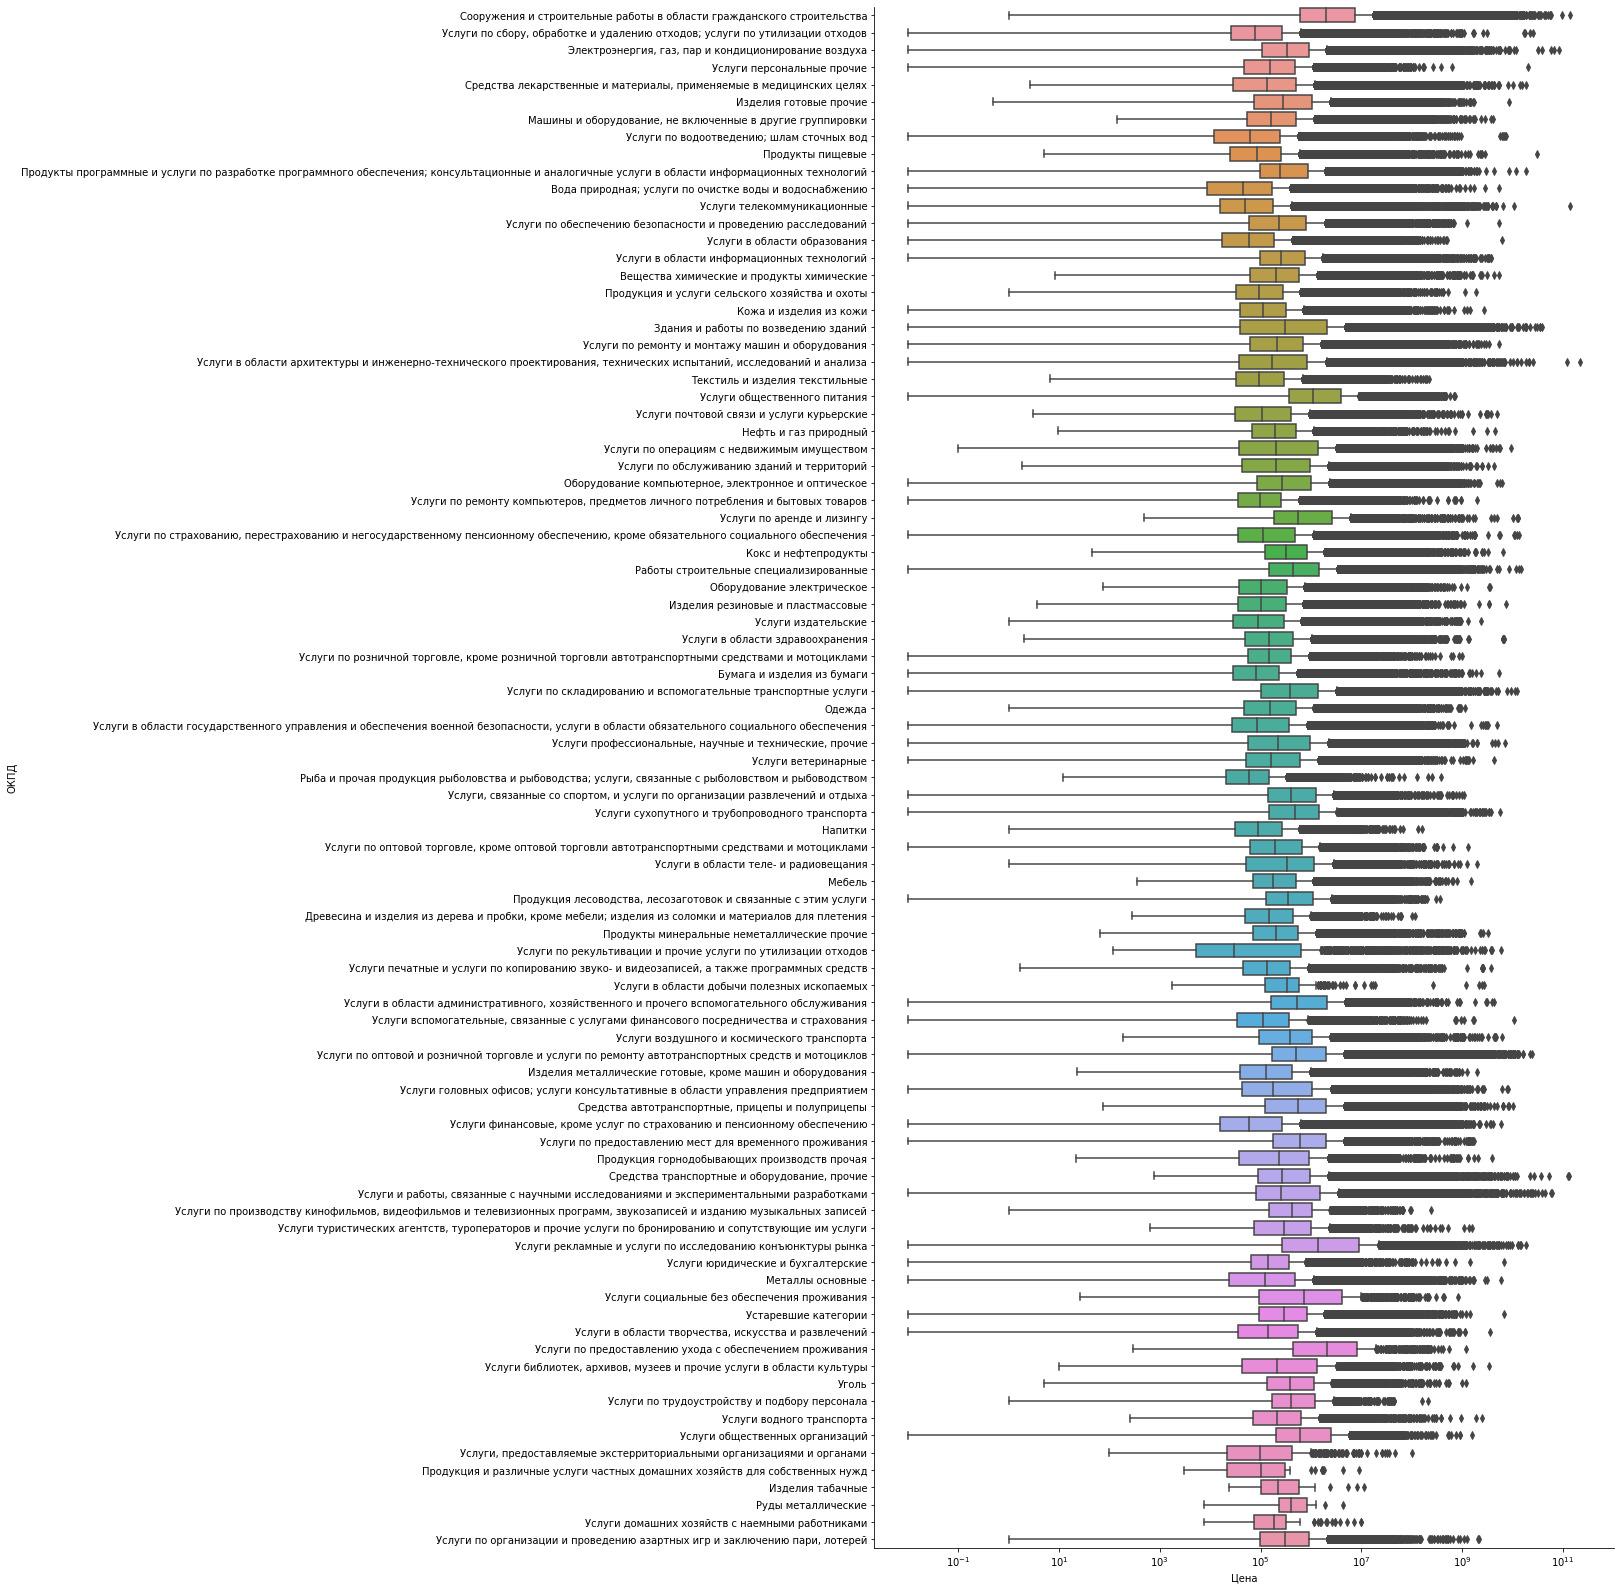

In [33]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['product_code', 'price'])
  data_to_plot['product_code'] = data_to_plot['product_code'].map(OKPD_mapping)
  g = sbs.catplot(y = 'product_code', x = 'price', kind ='box', height = 22, aspect = 0.5, data = data_to_plot, orient = 'h')
  g.set(xscale = 'log', xlabel = 'Цена', ylabel = 'ОКПД')

del data_to_plot
del g
gc.collect()

Результат: некоторая корреляция присутсвует

## Цена и продолжительность

Гипотеза: время и цена коррелируют. 
Выше продолжительность -> Выше цена.

In [34]:
# Корреляционная матрица
data[list(set(num_var))].corr()

,price,time
price,1.000000,0.053357
time,0.053357,1.000000


53519

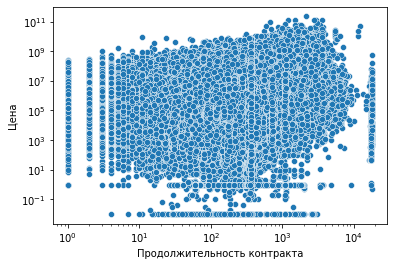

In [35]:
g = sbs.scatterplot(x = 'time', y = 'price', data = data)
g.set(xscale = 'log', yscale = 'log', xlabel = 'Продолжительность контракта', ylabel = 'Цена')

del g
gc.collect()

In [36]:
def period_mapping(time):
  if (time <= 30):
    return '0-30'
  elif (30 < time <= 120):
    return '30-120'
  elif (120 < time <= 360):
    return '120-360'
  elif (360 < time <= 720):
    return '360-720'
  else:
    return '>720'

11981

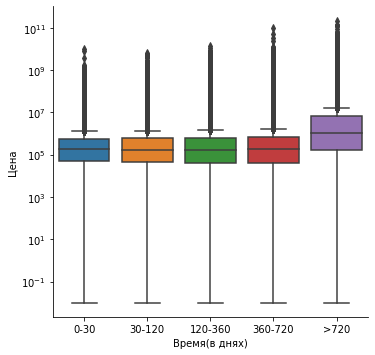

In [37]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['time', 'price'], axis = 1).sort_values('time')
  data_to_plot['time'] = data_to_plot['time'].map(period_mapping)
  g = sbs.catplot(x = 'time', y = 'price', kind ='box', aspect = 1, data = data_to_plot)
  g.set(yscale = 'log', xlabel = 'Время(в днях)', ylabel = 'Цена')

del data_to_plot
del g
gc.collect()

Результат: Время и цена коррелируют слабо до продолжиткельности ~720 дней, после этого идет тренд на повышение цен

## Продолжительность и тип клиента

Гипотеза: тип клиента и продолжительность контракта коррелируют

7066

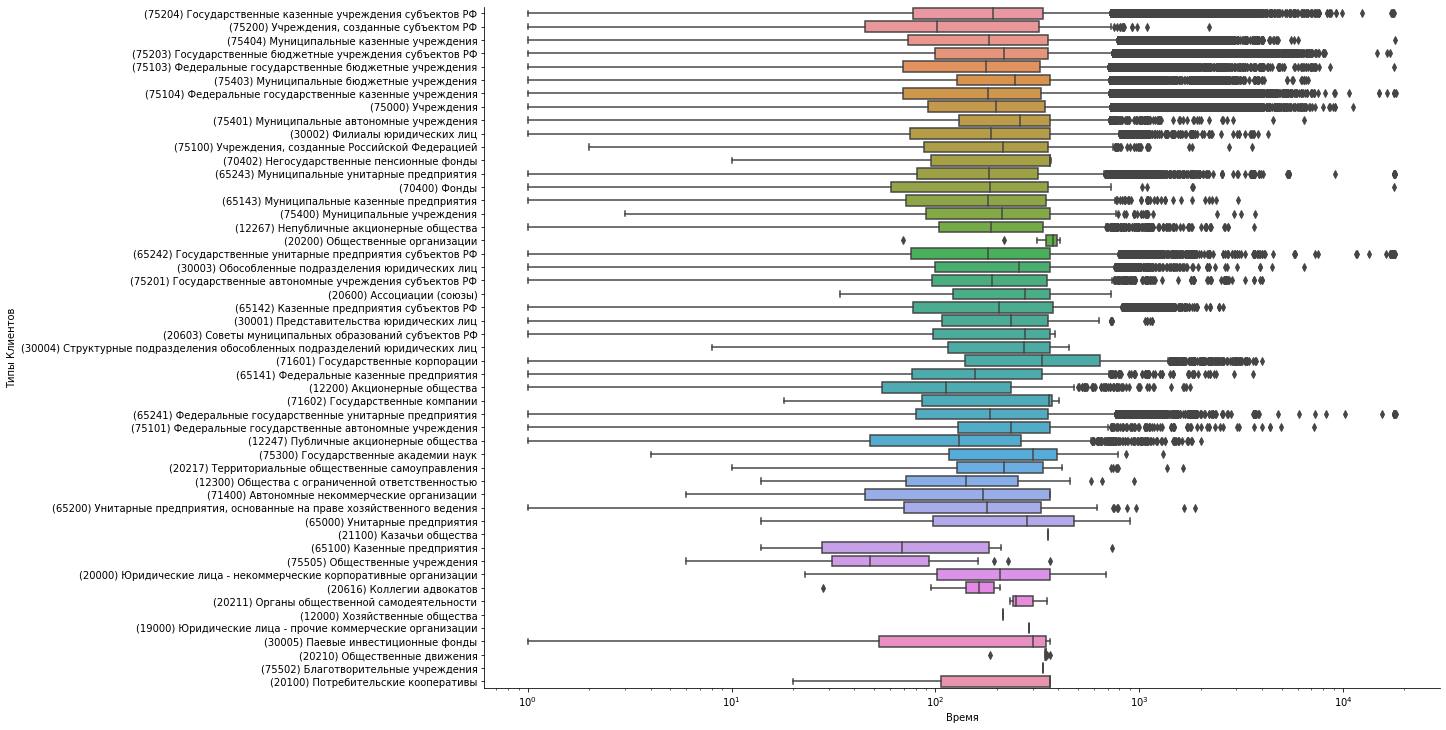

In [38]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['customer_legal_form', 'time'], axis=1)
  data_to_plot['customer_legal_form'] = data_to_plot['customer_legal_form'].map(OKOPF_sub)
  g = sbs.catplot(y = 'customer_legal_form', x = 'time', kind ='box', height = 10, aspect = 2, data = data_to_plot, orient = 'h')
  g.set(xscale = 'log', xlabel = 'Время', ylabel = 'Типы Клиентов')

del data_to_plot
del g
gc.collect()

Результат: Есть некоторые категории покупателей в которых продолжительность заключена в ограниченые рамки(юридические лица и их производные), в остальных же не наблюдается явной зависимости

## Продолжительность и тип поставщика

Гипотеза: тип поставщика и продолжительность контракта коррелируют

In [ ]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['supplier_legal_form', 'time'], axis=1)
  data_to_plot['supplier_legal_form'] = data_to_plot['supplier_legal_form'].map(OKOPF_sub)
  g = sbs.catplot(y = 'supplier_legal_form', x = 'time', kind ='box', height = 15, aspect = 2, data = data_to_plot, orient = 'h')
  g.set(xscale = 'log', xlabel = 'Время', ylabel = 'Типы Поставщиков')

del data_to_plot
del g
gc.collect()

## Продолжительность и тип продукта

Гипотеза: от типа поставляемого продукта зависит продолжительность контракта

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


89

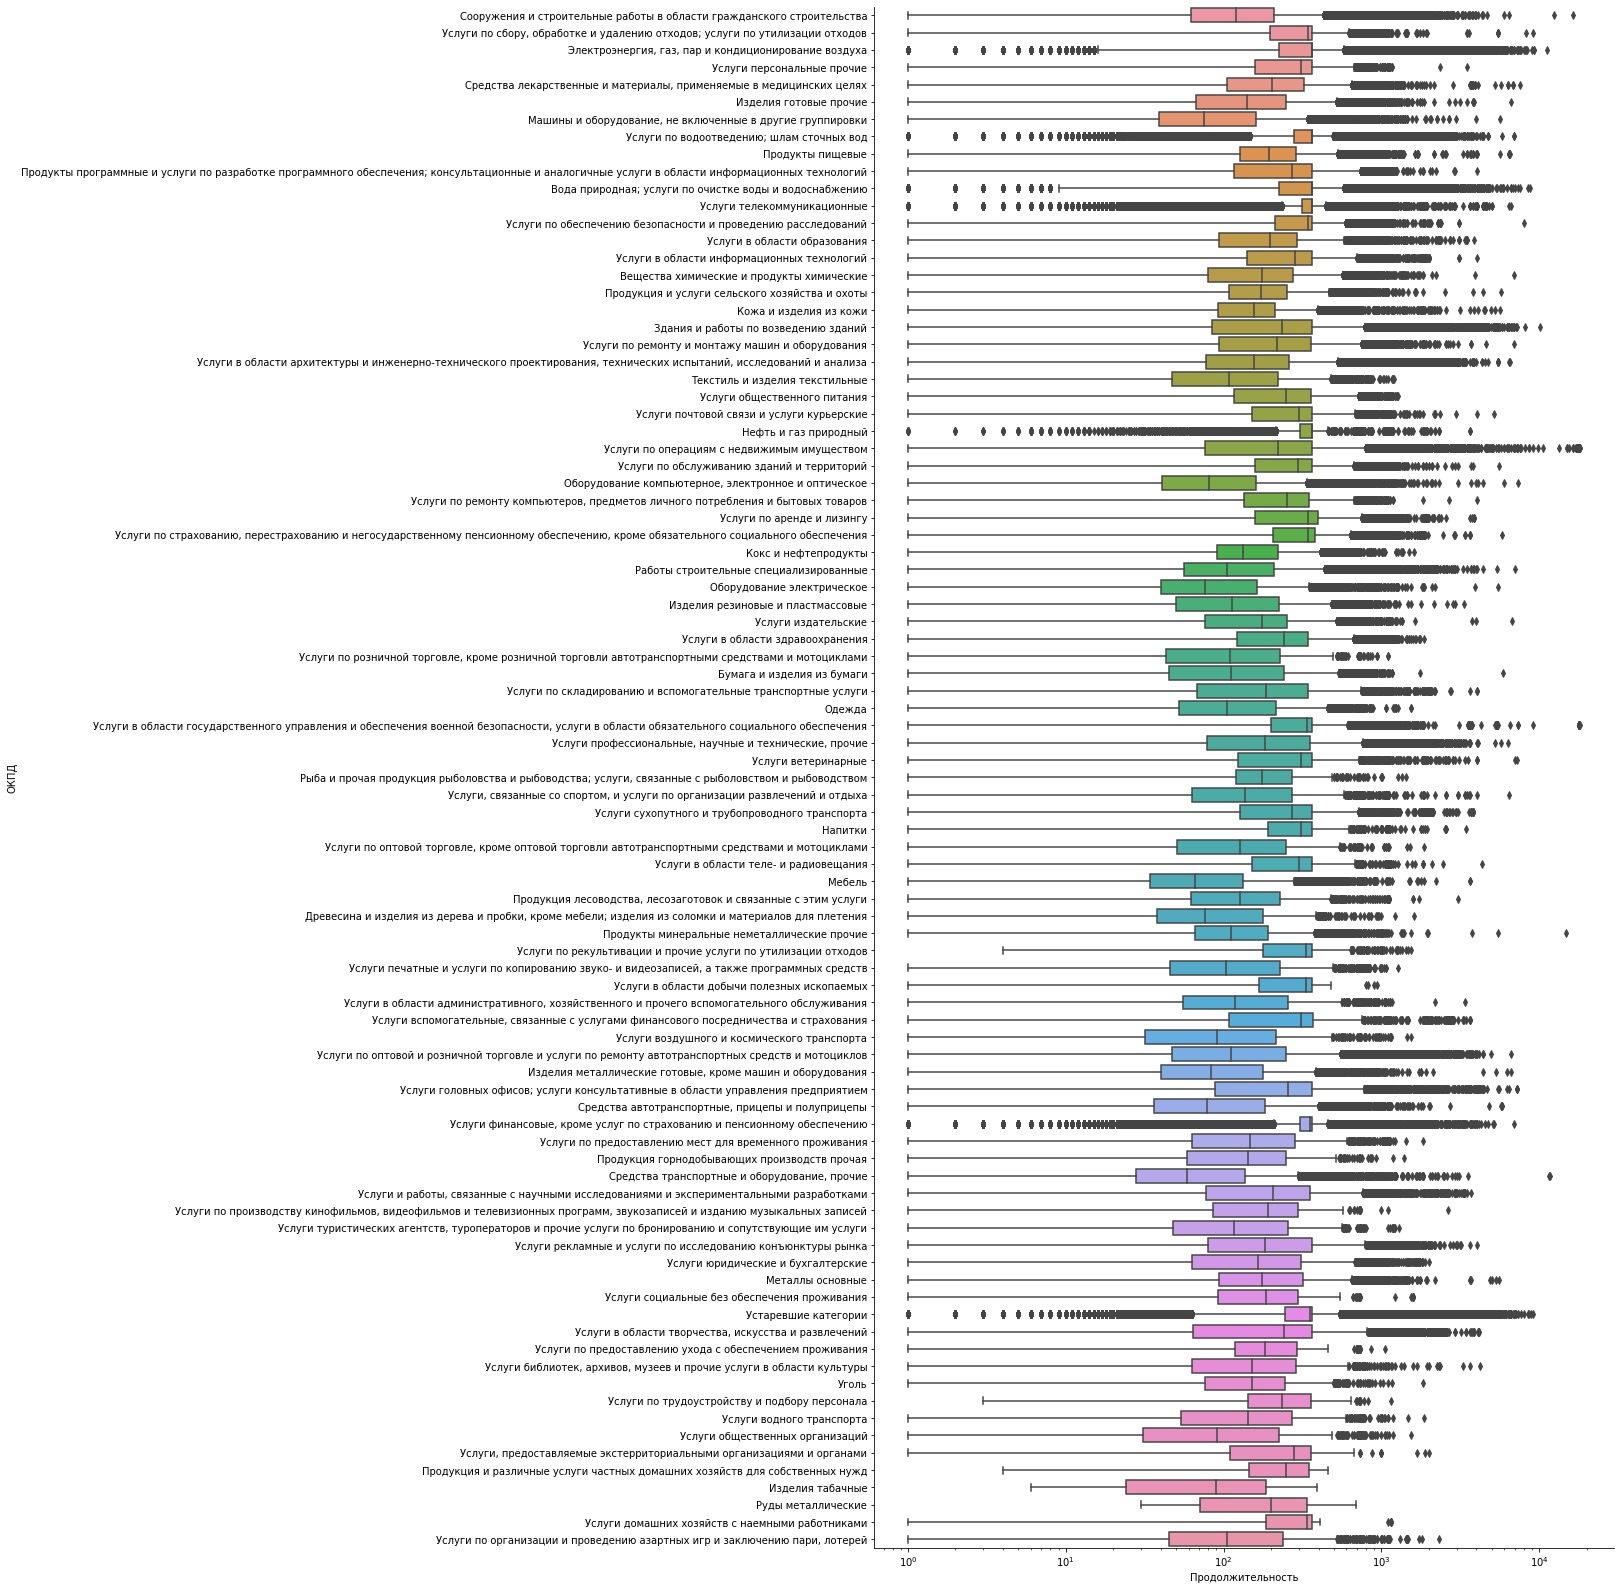

In [41]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['product_code', 'time'])
  data_to_plot['product_code'] = data_to_plot['product_code'].map(OKPD_mapping)
  g = sbs.catplot(y = 'product_code', x = 'time', kind ='box', height = 22, aspect = 0.5, data = data_to_plot, orient = 'h')
  g.set(xscale = 'log', xlabel = 'Продолжительность', ylabel = 'ОКПД')


del data_to_plot
del g
gc.collect()

Результат: Корреляция (в среднем) наблюдается, нет четкой нижней границы у многих категорий

## Типы продукта и типы покупателя

Гипотеза: Некоторые типы покупателей заключают относительно небольшой список типов товаров

Разнообразие типов продукта в контрактах покупателя

Мера разнообразия может служить как связующий элемент для объяснения зависимости некоторых категорий(продолжительность-тип продукта-тип покупателя,цена-тип продукта-тип покупателя), а также демонстрирует зависимость некоторых типов покупателя и типов продукта ими приобретаемых.

129

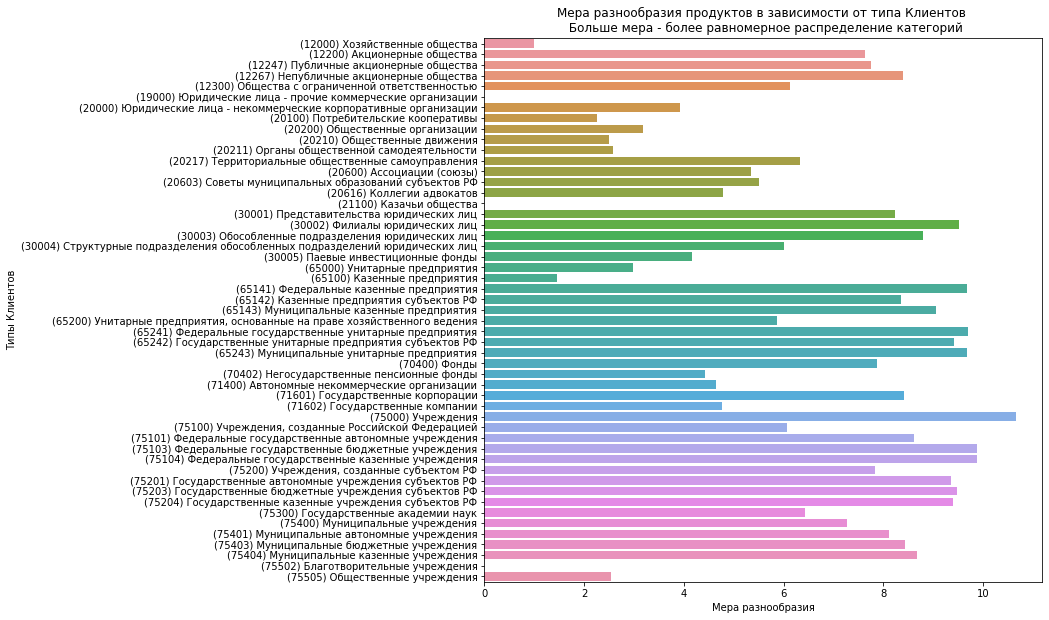

In [42]:
#Формула Шеннона
def variety_index(row):
  variety_index = 0.0
  sum = row.sum()
  for i in row:
    if i > 0:
      p = i / sum
      variety_index -= p * math.log(p, 2) 
  return variety_index
  

with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['customer_legal_form', 'product_code', 'reg_num'], axis=1)
  data_to_plot['customer_legal_form'] = data_to_plot['customer_legal_form'].map(OKOPF_sub)
  customer_legal_form_variety_index = data_to_plot.groupby(['customer_legal_form', 'product_code']).size().unstack().apply(variety_index, axis=1)
  a4_dims = (10, 10)
  fig, ax = plt.subplots(figsize=a4_dims)
  g = sbs.barplot(ax = ax, x = customer_legal_form_variety_index.values, y = customer_legal_form_variety_index.index, orient = 'h')
  g.set(xscale = 'linear', xlabel = 'Мера разнообразия', ylabel = 'Типы Клиентов')
  g.set_title('Мера разнообразия продуктов в зависимости от типа Клиентов \n Больше мера - более равномерное распределение категорий')

del fig, ax
del g
del data_to_plot, customer_legal_form_variety_index
gc.collect()

Тип клиента и самый часто закупаемый им тип продукта

In [43]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['customer_legal_form', 'product_code', 'reg_num'], axis=1)
  data_to_plot['customer_legal_form'] = data_to_plot['customer_legal_form'].map(OKOPF_sub)
  data_to_plot['product_code'] = data_to_plot['product_code'].map(OKPD_mapping)
  customer_legal_form_product_type = data_to_plot.groupby(['customer_legal_form', 'product_code']).size().unstack().transpose().idxmax()
  print(customer_legal_form_product_type)


del data_to_plot, customer_legal_form_product_type
gc.collect()

customer_legal_form
(12000) Хозяйственные общества                                                                             Кожа и изделия из кожи
(12200) Акционерные общества                                                     Средства автотранспортные, прицепы и полуприцепы
(12247) Публичные акционерные общества                                          Машины и оборудование, не включенные в другие ...
(12267) Непубличные акционерные общества                                        Машины и оборудование, не включенные в другие ...
(12300) Общества с ограниченной ответственностью                                Услуги по оптовой и розничной торговле и услуг...
(19000) Юридические лица - прочие коммерческие организации                      Услуги финансовые, кроме услуг по страхованию ...
(20000) Юридические лица - некоммерческие корпоративные организации             Услуги по оптовой и розничной торговле и услуг...
(20100) Потребительские кооперативы                                   

12079

Результат: типы продуктов и типы покупателей проявляют некоторую корреляцию(в типах клиентов с низкой мерой разнообразия), что позволяет объяснить корреляцию некоторых типов покупателей с ценой и продолжительностью контракта(Акционерные общества, Юридические лица, ООО)

## Общее распределение завершенности

Распределение контрактов по степеням завершенности - ожидаемое, малое кол-во продолжающихся контрактов, большое количество разорванных и заверщенных контрактов.

30

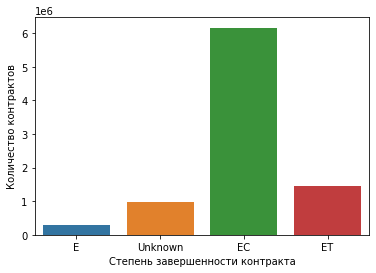

In [44]:
g = sbs.countplot(x = 'current_contract_stage', data = data)
g.set(xlabel = 'Степень завершенности контракта', ylabel = 'Количество контрактов')

del g
gc.collect()

Для каждого из типов клиента сохраняется похожее распределение, кроме типов с малым кол-вом контрактов и муниципальных бюджетных учреждений(примерно 50% прекращенных контрактов), для других типов доля ЕС к ЕТ колеблется от 4:1 до 10:1.

2343

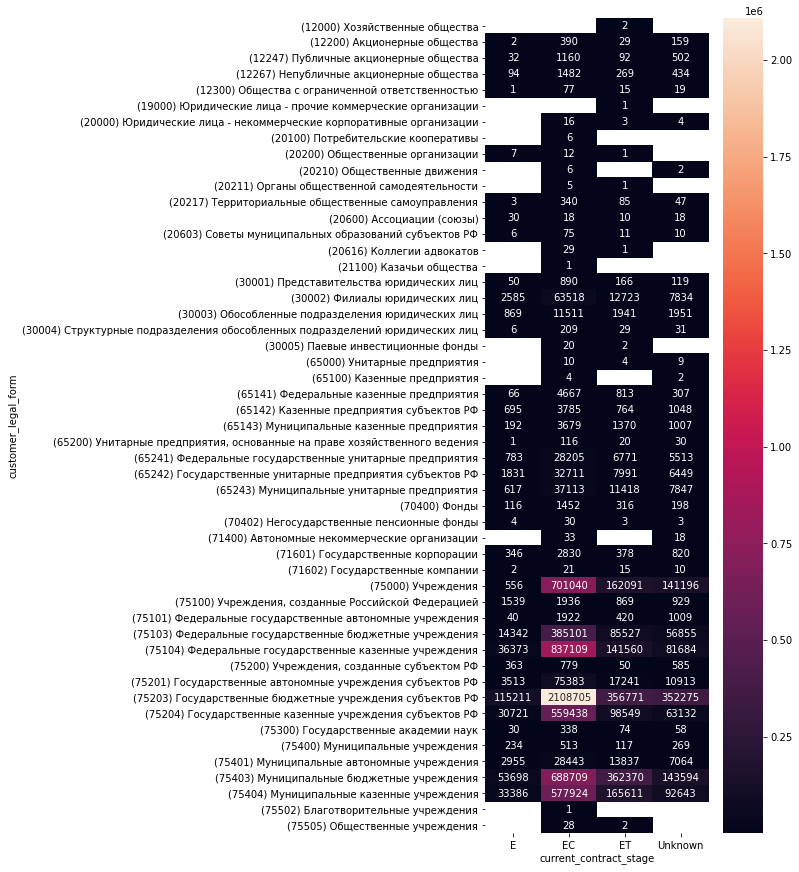

In [45]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['customer_legal_form', 'current_contract_stage', 'reg_num'], axis=1)
  data_to_plot['customer_legal_form'] = data_to_plot['customer_legal_form'].map(OKOPF_sub)
  customer_legal_form_x_stage = data_to_plot.groupby(['customer_legal_form', 'current_contract_stage']).size().unstack()
  a4_dims = (5, 15)
  fig, ax = plt.subplots(figsize=a4_dims)
  sbs.heatmap(ax = ax, data = customer_legal_form_x_stage, annot=True, fmt='0.0f')

del fig, ax
del data_to_plot, customer_legal_form_x_stage
gc.collect()

## Завершенность и продолжительность

Продолжающиеся контракты разбиваются на две группы - продолжительные(большинство, так как накапливаются за продолжительное время) и короткие(меньшинство, так как быстро заканчиваются).
Большинство завершенных контрактов - короткие.

189

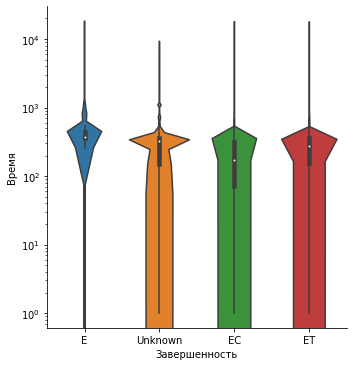

In [46]:
g = sbs.catplot(x = 'current_contract_stage', y = 'time', kind ='violin', aspect = 1, data = data)
g.set(yscale = 'log', xlabel = 'Завершенность', ylabel = 'Время')

del g
gc.collect()

Подобное распределение сохраняется для кажого типа клиента в отдельности, однако, стоит отметить, что контракты ЕС в среднем короче(на 33-50%) чем контракты ЕТ, что плохо видно на графике выше.

8685

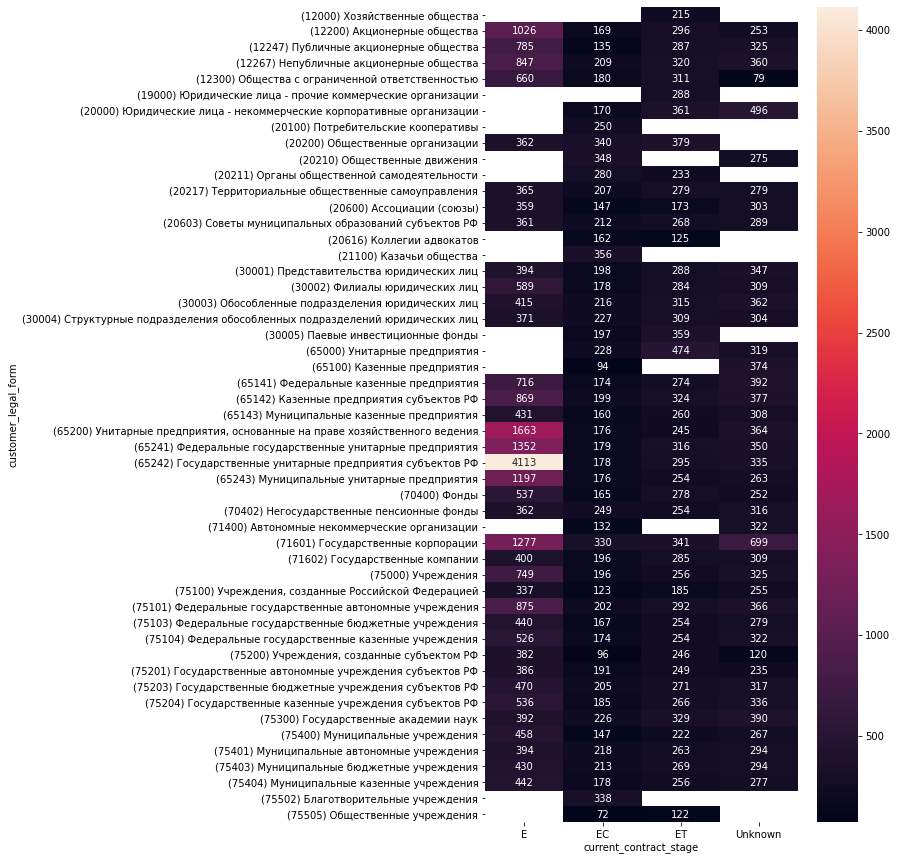

In [47]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['customer_legal_form', 'current_contract_stage', 'time'], axis=1)
  data_to_plot['customer_legal_form'] = data_to_plot['customer_legal_form'].map(OKOPF_sub)
  customer_legal_form_x_mean_time = data_to_plot.groupby(['customer_legal_form', 'current_contract_stage']).mean(['time'])['time'].unstack()
  a4_dims = (7, 15)
  fig, ax = plt.subplots(figsize=a4_dims)
  sbs.heatmap(ax = ax, data = customer_legal_form_x_mean_time, annot=True, fmt='.0f')

del fig, ax
del data_to_plot, customer_legal_form_x_mean_time
gc.collect()

## Завершенность и цена

Цена продолжающихся контрактов - выше среднего

139

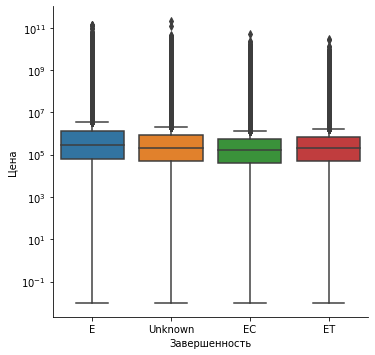

In [48]:
g = sbs.catplot(x = 'current_contract_stage', y = 'price', kind ='box', aspect = 1, data = data)
g.set(yscale = 'log', xlabel = 'Завершенность', ylabel = 'Цена')

del g
gc.collect()

5762

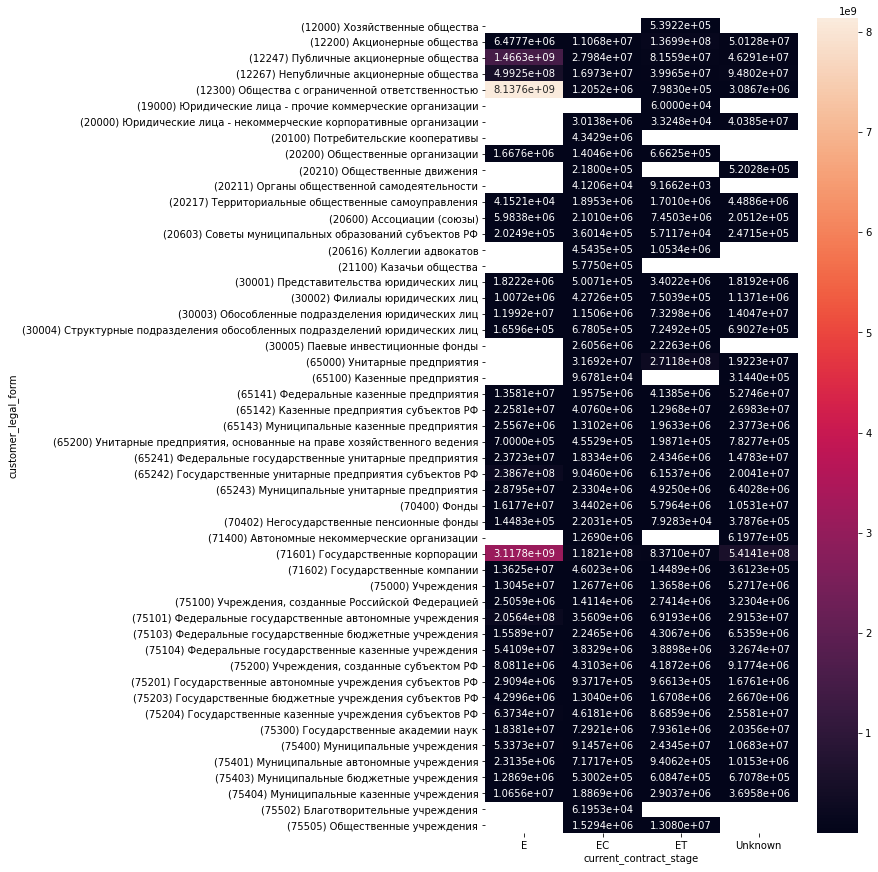

In [49]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['customer_legal_form', 'current_contract_stage', 'price'], axis=1)
  data_to_plot['customer_legal_form'] = data_to_plot['customer_legal_form'].map(OKOPF_sub)
  customer_legal_form_x_mean_price = data_to_plot.groupby(['customer_legal_form', 'current_contract_stage']).mean(['price'])['price'].unstack()
  a4_dims = (7, 15)
  fig, ax = plt.subplots(figsize=a4_dims)
  sbs.heatmap(ax = ax, data = customer_legal_form_x_mean_price, annot=True, fmt='.4e')

del fig, ax
del data_to_plot, customer_legal_form_x_mean_price
gc.collect()

##Средняя цена поставщика и кол-во контрактов

Гипотеза: кол-во контрактов поставщика коррелирует со средней ценой контракта

In [50]:
sup_data = data.groupby('supplier_inn').agg({'price' : ['mean'], 'reg_num' : ['count']})
sup_data = sup_data.dropna()

In [51]:
sup_data.sort_values(('price', 'mean'))

,price,reg_num
,mean,count
supplier_inn,,
0274184840,1.000000e-02,1
0273906235,1.000000e-02,4
2722119094,1.000000e-02,4
2901203271,1.000000e-02,1
1660216079,1.000000e-02,1
...,...,...
7706241963,4.181903e+10,3
7728645409,4.703708e+10,1


In [52]:
sup_data.sort_values(('reg_num', 'count'))

,price,reg_num
,mean,count
supplier_inn,,
8913005606,9.100000e+04,1
9715360833,2.029683e+06,1
8603167866,8.054550e+05,1
8603189294,1.971975e+05,1
8604061321,1.441945e+05,1
...,...,...
7724261610,1.348511e+06,47497
7724922443,1.811638e+05,62886


In [53]:
sup_data.describe()

,price,reg_num
,mean,count
count,2.891380e+05,289138.000000
mean,9.062484e+06,30.781215
std,3.869348e+08,569.326137
min,1.000000e-02,1.000000
25%,1.302081e+05,1.000000
50%,4.098673e+05,4.000000
75%,1.558491e+06,13.000000
max,1.385575e+11,221228.000000


15166

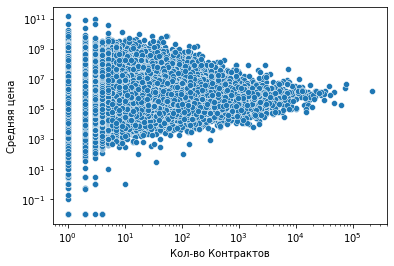

In [54]:
g = sbs.scatterplot(x = ('reg_num', 'count'), y = ('price', 'mean'), data = sup_data)
g.set(xscale = 'log', yscale = 'log', xlabel = 'Кол-во Контрактов', ylabel = 'Средняя цена')

del g
gc.collect()

Результат: Большее количество контрактов ограничивает среднюю цену в некотором промежутке. Больше контрактов -> цена стремится к "средней".